# Homework 2: CTC Speech Recognition System
You can do this notebook in google collab, or in datasphere (if you are brave enougth)

### Grades criteria

```
[ ] (10 points) Implement a Prefix Decoder
[ ] (10 points) Train ASR System, WER criterions: 60-50 -- 3 points, 50-40 -- 5 points, 40-35 -- 7 points, <=35 -- 10 points. + Bonus point per 1% WER below 30
[ ] (5 points) Compare performance of DNN, RNN and BiRNN models in terms of WER, training time and other properties
[ ] (5 points) Compare alignments obtained from DNN, RNN and BiRNN models
```

The results of this task are two artifacts:
1. this Jupiter Notebook (`.ipynb`) with completed cells, training progress and final score.
2. file with predictions of your best model for the test data

Save the artifacts to a directory named `{your last name}_{your first name}_hw2` and pack them in `.zip` archive.


In [ ]:
#!L
#%pip install torch==1.7.1+cu101 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html
#%pip install https://github.com/kpu/kenlm/archive/master.zip
#%pip install dulwich
#%pip install --user -U arpa

# %enable_full_walk

## Clone github repo

In [2]:
#!L

import dulwich.client
from dulwich.repo import Repo
from dulwich import index

import os
import shutil

def git_clone(src, target):
    client, path = dulwich.client.get_transport_and_path(src)
    if os.path.isdir(target):
        shutil.rmtree(target)
    os.makedirs(target)
    r = Repo.init(target)

    remote_refs = client.fetch(src, r)
    r[b"HEAD"] = remote_refs.refs[b"HEAD"]

    index.build_index_from_tree(r.path, r.index_path(), r.object_store, r[b'HEAD'].tree)

src = "https://github.com/yandexdataschool/speech_course"
target = "./speech_course"

git_clone(src, target)
os.listdir(target)

week_05_path = './speech_course/week_05' # Change this path, if it is different in your case

In [3]:
#!L
import importlib
import collections
import os
import math
import numpy as np
import time
import copy
from string import ascii_lowercase
import re
import random

from utils import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchaudio
from torch import optim
import arpa

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [4]:
#!L
# Download LibriSpeech 100hr training and test data

if not os.path.isdir("./data"):
    os.makedirs("./data")

train_dataset = torchaudio.datasets.LIBRISPEECH("./data", url="train-clean-100", download=True)
test_dataset = torchaudio.datasets.LIBRISPEECH("./data", url="test-clean", download=True)

## Tokenizer Class

In [5]:
#!L
# Class to transform text to strings of token indecies
class Tokenizer:
    """Maps characters to integers and vice versa"""
    def __init__(self):
        char_map_str = """
        ' 0
        _ 1
        a 2
        b 3
        c 4
        d 5
        e 6
        f 7
        g 8
        h 9
        i 10
        j 11
        k 12
        l 13
        m 14
        n 15
        o 16
        p 17
        q 18
        r 19
        s 20
        t 21
        u 22
        v 23
        w 24
        x 25
        y 26
        z 27
        """
        self.char_map = {}
        self.index_map = {}
        for line in char_map_str.strip().split('\n'):
            ch, index = line.split()
            self.char_map[ch] = int(index)
            self.index_map[int(index)] = ch
        self.index_map[1] = ' '

    def text_to_indecies(self, text):
        """ Use a character map and convert text to an integer sequence """
        int_sequence = []
        for c in text:
            if c == ' ':
                ch = self.char_map['_']
            else:
                ch = self.char_map[c]
            int_sequence.append(ch)
        return int_sequence

    def indecies_to_text(self, labels):
        """ Use a character map and convert integer labels to an text sequence """
        string = []
        for i in labels:
            string.append(self.index_map[i])
        return ''.join(string).replace('_', ' ')
tokenizer = Tokenizer()

In [6]:
#!L

def GreedyDecoder(output: torch.Tensor, labels: list, label_lengths: list, blank_label=28, collapse_repeated=True):
    """ist
    :param output: torch.Tensor of Probs or Log-Probs of shape [batch, time, classes]
    :param labels: Listof torch.Tensor of label indecies
    :param label_lengths:  int of label lengths
    :param blank_label:
    :param collapse_repeated:
    :return: 
    """

    # Get max class
    arg_maxes = torch.argmax(output, axis=-1)

    decodes = []
    targets = []

    #For targets and decodes remove r
    for i, args in enumerate(arg_maxes):
        decode = []

        targets.append(tokenizer.indecies_to_text(labels[i][:label_lengths[i]].tolist()))

        # Remove repeeats, then remove blanks

        for j, index in enumerate(args):
            if index != blank_label:
                if collapse_repeated and j != 0 and index == args[j - 1]:
                    continue
                decode.append(index.item())
        decodes.append(tokenizer.indecies_to_text(decode))
    return decodes, targets

In [7]:
#!L
# TESTING THE GREEDY DECODER 

#Load numpy matrix, add axis [batch,classes,time]
matrix = np.loadtxt(os.path.join(week_05_path, 'test_matrix.txt'))[np.newaxis,:,:]

# Turn into Torch Tensor of shape [batch, time, classes]
matrix = torch.Tensor(matrix).transpose(1,2)

# Create list of torch tensor
labels_indecies = [torch.Tensor(tokenizer.text_to_indecies('there seems no good reason for believing that it will change'))]

# Run the Decoder
decodes, targets = GreedyDecoder(matrix, labels_indecies, [len(labels_indecies[0])])

assert decodes[0] == 'there se ms no good reason for believing that twillc ange'
assert targets[0] == 'there seems no good reason for believing that it will change'



## Implement Prefix Decoding With LM (10 points)

In [8]:
def _BeamSearchDecoder(probs, lm, alpha=0.1, beta=2, beam_size=5, blank=28, space=1, prune=1e-5):
    """
    Performs prefix beam search on the output of a CTC network.
    Args:
        ctc (np.ndarray): The CTC output. Should be a 2D array (timesteps x alphabet_size)
        lm (func): Language model function. Should take as input a string and output a probability.
        k (int): The beam width. Will keep the 'k' most likely candidates at each timestep.
        alpha (float): The language model weight. Should usually be between 0 and 1.
        beta (float): The language model compensation term. The higher the 'alpha', the higher the 'beta'.
        prune (float): Only extend prefixes with chars with an emission probability higher than 'prune'.
    Retruns:
        string: The decoded CTC output.
    """
    ctc = copy.deepcopy(probs)

    lm = (lambda l: 1) if lm is None else lm # if no LM is provided, just set to function returning 1
    W = lambda l: re.findall(r'\w+[\s|\_]', l)
    alphabet = list(map(lambda x: x[1], sorted(tokenizer.index_map.items()))) + ['%']
    F = ctc.shape[1]
    ctc = np.vstack((np.zeros(F), ctc)) # just add an imaginative zero'th step (will make indexing more intuitive)
    T = ctc.shape[0]

    # STEP 1: Initiliazation
    O = ''
    Pb, Pnb = collections.defaultdict(collections.Counter), collections.defaultdict(collections.Counter)
    Pb[0][O] = 1
    Pnb[0][O] = 0
    A_prev = [O]
    # END: STEP 1

    # STEP 2: Iterations and pruning
    for t in range(1, T):
        pruned_alphabet = [alphabet[i] for i in np.where(ctc[t] > prune)[0]]
        for l in A_prev:
            for c in pruned_alphabet:
                c_ix = alphabet.index(c)
                # END: STEP 2
                
                # STEP 3: “Extending” with a blank
                if c == '%':
                    Pb[t][l] += ctc[t][-1] * (Pb[t - 1][l] + Pnb[t - 1][l])
                # END: STEP 3
                
                # STEP 4: Extending with the end character
                else:
                    l_plus = l + c
                    if len(l) > 0 and c == l[-1]:
                        Pnb[t][l_plus] += ctc[t][c_ix] * Pb[t - 1][l]
                        Pnb[t][l] += ctc[t][c_ix] * Pnb[t - 1][l]
                # END: STEP 4

                    # STEP 5: Extending with any other non-blank character and LM constraints
                    elif len(l.replace(' ', '').replace('_', '')) > 0 and c in (' ', '_'):
                        try:
                            lm_prob = lm(l_plus.strip(' _').upper()) ** alpha
                        except KeyError:
                            lm_prob = 0.0
                        Pnb[t][l_plus] += lm_prob * ctc[t][c_ix] * (Pb[t - 1][l] + Pnb[t - 1][l])
                    else:
                        Pnb[t][l_plus] += ctc[t][c_ix] * (Pb[t - 1][l] + Pnb[t - 1][l])
                    # END: STEP 5

                    # STEP 6: Make use of discarded prefixes
                    if l_plus not in A_prev:
                        Pb[t][l_plus] += ctc[t][-1] * (Pb[t - 1][l_plus] + Pnb[t - 1][l_plus])
                        Pnb[t][l_plus] += ctc[t][c_ix] * Pnb[t - 1][l_plus]
                    # END: STEP 6

        # STEP 7: Select most probable prefixes
        A_next = Pb[t] + Pnb[t]
        sorter = lambda l: A_next[l] * (len(W(l)) + 1) ** beta
        A_prev = sorted(A_next, key=sorter, reverse=True)[:beam_size]
        # END: STEP 7
    return A_prev[0].strip('_'), sorter(A_prev[0])


def BeamSearchDecoder(probs, labels, label_lengths, input_lengths, lm, beam_size=35, blank=28, space=1, prune=1e-3, alpha=0.1, beta=2):
    probs = probs.cpu().detach().numpy()
    decodes, targets = [], []
    for i, prob in enumerate(probs):

        targets.append(tokenizer.indecies_to_text(labels[i][:label_lengths[i]].tolist()))
        seq, _ = _BeamSearchDecoder(prob[:input_lengths[i]], lm=lm, beam_size=beam_size, blank=blank, prune=prune, alpha=alpha, beta=beta)
        decodes.append(seq)
        
    return decodes, targets

In [9]:
#Create LM
import arpa
alm = arpa.loadf('3-gram.pruned.1e-7.arpa')[0]


#Load numpy matrix, add axis [batch,classes,time]
matrix = np.loadtxt('test_matrix.txt')[np.newaxis,:,:]

# Turn into Torch Tensor of shape [batch, time, classes]
matrix = torch.Tensor(matrix).transpose(1,2)


labels_indecies = [torch.Tensor(tokenizer.text_to_indecies('there seems no good reason for believing that it will change'))]

In [10]:
#!L
# TESTING PREFIX Decoder

#Run the Decoder
decodes, targets = BeamSearchDecoder(matrix, labels_indecies, [len(labels_indecies[0])], [matrix.size()[1]], lm=None, beam_size=100, prune=1e-3, alpha=0.1, beta=2)

print(decodes[0])
assert decodes[0] == 'there se ms no good reason for believing that twil c ange'
assert targets[0] == 'there seems no good reason for believing that it will change'

decodes, targets = BeamSearchDecoder(matrix, labels_indecies, [len(labels_indecies[0])], [matrix.size()[1]], lm=alm.p, beam_size=100, prune=1e-3, alpha=0.1, beta=2)

print(decodes[0])
# assert decodes[0] == 'there seems no good reason for believing that twillc ange'
assert targets[0] == 'there seems no good reason for believing that it will change'



there se ms no good reason for believing that twil c ange
there seems no good reason for believing that twillchange


## Deep Learning part

## Create a Dataloader

In [11]:
def freq_mask(spec, F=15, num_masks=1, replace_with_zero=False):
    cloned = spec.clone()
    num_mel_channels = cloned.shape[1]

    for i in range(0, num_masks):
        f = random.randrange(0, F)
        f_zero = random.randrange(0, num_mel_channels - f)

        # avoids randrange error if values are equal and range is empty
        if (f_zero == f_zero + f): return cloned

        mask_end = random.randrange(f_zero, f_zero + f)
        if (replace_with_zero):
            cloned[0][f_zero:mask_end] = 0
        else:
            cloned[0][f_zero:mask_end] = cloned.mean()

    return cloned


def time_mask(spec, T=15, num_masks=1, replace_with_zero=False):
    cloned = spec.clone()
    len_spectro = cloned.shape[2]

    for i in range(0, num_masks):
        t = random.randrange(0, T)
        t_zero = random.randrange(0, len_spectro - t)

        # avoids randrange error if values are equal and range is empty
        if (t_zero == t_zero + t): return cloned

        mask_end = random.randrange(t_zero, t_zero + t)
        if (replace_with_zero):
            cloned[0][:, t_zero:mask_end] = 0
        else:
            cloned[0][:, t_zero:mask_end] = cloned.mean()
    return cloned


def sparse_image_warp(img_tensor,
                      source_control_point_locations,
                      dest_control_point_locations,
                      interpolation_order=2,
                      regularization_weight=0.0,
                      num_boundaries_points=0):
    control_point_flows = (dest_control_point_locations - source_control_point_locations)

    batch_size, image_height, image_width = img_tensor.shape
    grid_locations = get_grid_locations(image_height, image_width)
    flattened_grid_locations = torch.tensor(flatten_grid_locations(grid_locations, image_height, image_width))

    flattened_flows = interpolate_spline(
        dest_control_point_locations,
        control_point_flows,
        flattened_grid_locations,
        interpolation_order,
        regularization_weight)

    dense_flows = create_dense_flows(flattened_flows, batch_size, image_height, image_width)

    warped_image = dense_image_warp(img_tensor, dense_flows)

    return warped_image, dense_flows


def get_grid_locations(image_height, image_width):
    """Wrapper for np.meshgrid."""

    y_range = np.linspace(0, image_height - 1, image_height)
    x_range = np.linspace(0, image_width - 1, image_width)
    y_grid, x_grid = np.meshgrid(y_range, x_range, indexing='ij')
    return np.stack((y_grid, x_grid), -1)


def flatten_grid_locations(grid_locations, image_height, image_width):
    return np.reshape(grid_locations, [image_height * image_width, 2])


def create_dense_flows(flattened_flows, batch_size, image_height, image_width):
    # possibly .view
    return torch.reshape(flattened_flows, [batch_size, image_height, image_width, 2])


def interpolate_spline(train_points, train_values, query_points, order, regularization_weight=0.0, ):
    # First, fit the spline to the observed data.
    w, v = solve_interpolation(train_points, train_values, order, regularization_weight)
    # Then, evaluate the spline at the query locations.
    query_values = apply_interpolation(query_points, train_points, w, v, order)

    return query_values


def solve_interpolation(train_points, train_values, order, regularization_weight):
    b, n, d = train_points.shape
    k = train_values.shape[-1]

    # First, rename variables so that the notation (c, f, w, v, A, B, etc.)
    # follows https://en.wikipedia.org/wiki/Polyharmonic_spline.
    # To account for python style guidelines we use
    # matrix_a for A and matrix_b for B.

    c = train_points
    f = train_values.float()

    matrix_a = phi(cross_squared_distance_matrix(c, c), order).unsqueeze(0)  # [b, n, n]
    #     if regularization_weight > 0:
    #         batch_identity_matrix = array_ops.expand_dims(
    #           linalg_ops.eye(n, dtype=c.dtype), 0)
    #         matrix_a += regularization_weight * batch_identity_matrix

    # Append ones to the feature values for the bias term in the linear model.
    ones = torch.ones(1, dtype=train_points.dtype).view([-1, 1, 1])
    matrix_b = torch.cat((c, ones), 2).float()  # [b, n, d + 1]

    # [b, n + d + 1, n]
    left_block = torch.cat((matrix_a, torch.transpose(matrix_b, 2, 1)), 1)

    num_b_cols = matrix_b.shape[2]  # d + 1

    # In Tensorflow, zeros are used here. Pytorch gesv fails with zeros for some reason we don't understand.
    # So instead we use very tiny randn values (variance of one, zero mean) on one side of our multiplication.
    lhs_zeros = torch.randn((b, num_b_cols, num_b_cols)) / 1e10
    right_block = torch.cat((matrix_b, lhs_zeros),
                            1)  # [b, n + d + 1, d + 1]
    lhs = torch.cat((left_block, right_block),
                    2)  # [b, n + d + 1, n + d + 1]

    rhs_zeros = torch.zeros((b, d + 1, k), dtype=train_points.dtype).float()
    rhs = torch.cat((f, rhs_zeros), 1)  # [b, n + d + 1, k]

    # Then, solve the linear system and unpack the results.
    X, LU = torch.solve(rhs, lhs)
    w = X[:, :n, :]
    v = X[:, n:, :]

    return w, v


def cross_squared_distance_matrix(x, y):
    """Pairwise squared distance between two (batch) matrices' rows (2nd dim).
        Computes the pairwise distances between rows of x and rows of y
        Args:
        x: [batch_size, n, d] float `Tensor`
        y: [batch_size, m, d] float `Tensor`
        Returns:
        squared_dists: [batch_size, n, m] float `Tensor`, where
        squared_dists[b,i,j] = ||x[b,i,:] - y[b,j,:]||^2
    """
    x_norm_squared = torch.sum(torch.mul(x, x))
    y_norm_squared = torch.sum(torch.mul(y, y))

    x_y_transpose = torch.matmul(x.squeeze(0), y.squeeze(0).transpose(0, 1))

    # squared_dists[b,i,j] = ||x_bi - y_bj||^2 = x_bi'x_bi- 2x_bi'x_bj + x_bj'x_bj
    squared_dists = x_norm_squared - 2 * x_y_transpose + y_norm_squared

    return squared_dists.float()


def phi(r, order):
    """Coordinate-wise nonlinearity used to define the order of the interpolation.
    See https://en.wikipedia.org/wiki/Polyharmonic_spline for the definition.
    Args:
    r: input op
    order: interpolation order
    Returns:
    phi_k evaluated coordinate-wise on r, for k = r
    """
    EPSILON = torch.tensor(1e-10)
    # using EPSILON prevents log(0), sqrt0), etc.
    # sqrt(0) is well-defined, but its gradient is not
    if order == 1:
        r = torch.max(r, EPSILON)
        r = torch.sqrt(r)
        return r
    elif order == 2:
        return 0.5 * r * torch.log(torch.max(r, EPSILON))
    elif order == 4:
        return 0.5 * torch.square(r) * torch.log(torch.max(r, EPSILON))
    elif order % 2 == 0:
        r = torch.max(r, EPSILON)
        return 0.5 * torch.pow(r, 0.5 * order) * torch.log(r)
    else:
        r = torch.max(r, EPSILON)
        return torch.pow(r, 0.5 * order)


def apply_interpolation(query_points, train_points, w, v, order):
    """Apply polyharmonic interpolation model to data.
    Given coefficients w and v for the interpolation model, we evaluate
    interpolated function values at query_points.
    Args:
    query_points: `[b, m, d]` x values to evaluate the interpolation at
    train_points: `[b, n, d]` x values that act as the interpolation centers
                    ( the c variables in the wikipedia article)
    w: `[b, n, k]` weights on each interpolation center
    v: `[b, d, k]` weights on each input dimension
    order: order of the interpolation
    Returns:
    Polyharmonic interpolation evaluated at points defined in query_points.
    """
    query_points = query_points.unsqueeze(0)
    # First, compute the contribution from the rbf term.
    pairwise_dists = cross_squared_distance_matrix(query_points.float(), train_points.float())
    phi_pairwise_dists = phi(pairwise_dists, order)

    rbf_term = torch.matmul(phi_pairwise_dists, w)

    # Then, compute the contribution from the linear term.
    # Pad query_points with ones, for the bias term in the linear model.
    ones = torch.ones_like(query_points[..., :1])
    query_points_pad = torch.cat((
        query_points,
        ones
    ), 2).float()
    linear_term = torch.matmul(query_points_pad, v)

    return rbf_term + linear_term


def dense_image_warp(image, flow):
    """Image warping using per-pixel flow vectors.
    Apply a non-linear warp to the image, where the warp is specified by a dense
    flow field of offset vectors that define the correspondences of pixel values
    in the output image back to locations in the  source image. Specifically, the
    pixel value at output[b, j, i, c] is
    images[b, j - flow[b, j, i, 0], i - flow[b, j, i, 1], c].
    The locations specified by this formula do not necessarily map to an int
    index. Therefore, the pixel value is obtained by bilinear
    interpolation of the 4 nearest pixels around
    (b, j - flow[b, j, i, 0], i - flow[b, j, i, 1]). For locations outside
    of the image, we use the nearest pixel values at the image boundary.
    Args:
    image: 4-D float `Tensor` with shape `[batch, height, width, channels]`.
    flow: A 4-D float `Tensor` with shape `[batch, height, width, 2]`.
    name: A name for the operation (optional).
    Note that image and flow can be of type tf.half, tf.float32, or tf.float64,
    and do not necessarily have to be the same type.
    Returns:
    A 4-D float `Tensor` with shape`[batch, height, width, channels]`
    and same type as input image.
    Raises:
    ValueError: if height < 2 or width < 2 or the inputs have the wrong number
    of dimensions.
    """
    image = image.unsqueeze(3)  # add a single channel dimension to image tensor
    batch_size, height, width, channels = image.shape

    # The flow is defined on the image grid. Turn the flow into a list of query
    # points in the grid space.
    grid_x, grid_y = torch.meshgrid(
        torch.arange(width), torch.arange(height))

    stacked_grid = torch.stack((grid_y, grid_x), dim=2).float()

    batched_grid = stacked_grid.unsqueeze(-1).permute(3, 1, 0, 2)

    query_points_on_grid = batched_grid - flow
    query_points_flattened = torch.reshape(query_points_on_grid,
                                           [batch_size, height * width, 2])
    # Compute values at the query points, then reshape the result back to the
    # image grid.
    interpolated = interpolate_bilinear(image, query_points_flattened)
    interpolated = torch.reshape(interpolated,
                                 [batch_size, height, width, channels])
    return interpolated


def interpolate_bilinear(grid,
                         query_points,
                         name='interpolate_bilinear',
                         indexing='ij'):
    """Similar to Matlab's interp2 function.
    Finds values for query points on a grid using bilinear interpolation.
    Args:
    grid: a 4-D float `Tensor` of shape `[batch, height, width, channels]`.
    query_points: a 3-D float `Tensor` of N points with shape `[batch, N, 2]`.
    name: a name for the operation (optional).
    indexing: whether the query points are specified as row and column (ij),
      or Cartesian coordinates (xy).
    Returns:
    values: a 3-D `Tensor` with shape `[batch, N, channels]`
    Raises:
    ValueError: if the indexing mode is invalid, or if the shape of the inputs
      invalid.
    """
    if indexing != 'ij' and indexing != 'xy':
        raise ValueError('Indexing mode must be \'ij\' or \'xy\'')

    shape = grid.shape
    if len(shape) != 4:
        msg = 'Grid must be 4 dimensional. Received size: '
        raise ValueError(msg + str(grid.shape))

    batch_size, height, width, channels = grid.shape

    shape = [batch_size, height, width, channels]
    query_type = query_points.dtype
    grid_type = grid.dtype

    num_queries = query_points.shape[1]

    alphas = []
    floors = []
    ceils = []
    index_order = [0, 1] if indexing == 'ij' else [1, 0]
    unstacked_query_points = query_points.unbind(2)

    for dim in index_order:
        queries = unstacked_query_points[dim]

        size_in_indexing_dimension = shape[dim + 1]

        # max_floor is size_in_indexing_dimension - 2 so that max_floor + 1
        # is still a valid index into the grid.
        max_floor = torch.tensor(size_in_indexing_dimension - 2, dtype=query_type)
        min_floor = torch.tensor(0.0, dtype=query_type)
        maxx = torch.max(min_floor, torch.floor(queries))
        floor = torch.min(maxx, max_floor)
        int_floor = floor.long()
        floors.append(int_floor)
        ceil = int_floor + 1
        ceils.append(ceil)

        # alpha has the same type as the grid, as we will directly use alpha
        # when taking linear combinations of pixel values from the image.
        alpha = torch.tensor(queries - floor, dtype=grid_type)
        min_alpha = torch.tensor(0.0, dtype=grid_type)
        max_alpha = torch.tensor(1.0, dtype=grid_type)
        alpha = torch.min(torch.max(min_alpha, alpha), max_alpha)

        # Expand alpha to [b, n, 1] so we can use broadcasting
        # (since the alpha values don't depend on the channel).
        alpha = torch.unsqueeze(alpha, 2)
        alphas.append(alpha)

    flattened_grid = torch.reshape(
        grid, [batch_size * height * width, channels])
    batch_offsets = torch.reshape(
        torch.arange(batch_size) * height * width, [batch_size, 1])

    # This wraps array_ops.gather. We reshape the image data such that the
    # batch, y, and x coordinates are pulled into the first dimension.
    # Then we gather. Finally, we reshape the output back. It's possible this
    # code would be made simpler by using array_ops.gather_nd.
    def gather(y_coords, x_coords, name):
        linear_coordinates = batch_offsets + y_coords * width + x_coords
        gathered_values = torch.gather(flattened_grid.t(), 1, linear_coordinates)
        return torch.reshape(gathered_values,
                             [batch_size, num_queries, channels])

    # grab the pixel values in the 4 corners around each query point
    top_left = gather(floors[0], floors[1], 'top_left')
    top_right = gather(floors[0], ceils[1], 'top_right')
    bottom_left = gather(ceils[0], floors[1], 'bottom_left')
    bottom_right = gather(ceils[0], ceils[1], 'bottom_right')

    interp_top = alphas[1] * (top_right - top_left) + top_left
    interp_bottom = alphas[1] * (bottom_right - bottom_left) + bottom_left
    interp = alphas[0] * (interp_bottom - interp_top) + interp_top

    return interp


def time_warp(spec, W=5):
    num_rows = spec.shape[1]
    spec_len = spec.shape[2]

    y = num_rows // 2
    horizontal_line_at_ctr = spec[0][y]
    # assert len(horizontal_line_at_ctr) == spec_len

    point_to_warp = horizontal_line_at_ctr[random.randrange(W, spec_len-W)]
    # assert isinstance(point_to_warp, torch.Tensor)

    # Uniform distribution from (0,W) with chance to be up to W negative
    dist_to_warp = random.randrange(-W, W)
    src_pts = torch.tensor([[[y, point_to_warp]]])
    dest_pts = torch.tensor([[[y, point_to_warp + dist_to_warp]]])
    warped_spectro, dense_flows = sparse_image_warp(spec, src_pts, dest_pts)
    return warped_spectro.squeeze(3)


def spec_augment(mel_spectrogram, time_warping_para=80, frequency_masking_para=27,
                 time_masking_para=100, frequency_mask_num=1, time_mask_num=1):
    """Spec augmentation Calculation Function.
    'SpecAugment' have 3 steps for audio data augmentation.
    first step is time warping using Tensorflow's image_sparse_warp function.
    Second step is frequency masking, last step is time masking.
    # Arguments:
      mel_spectrogram(numpy array): audio file path of you want to warping and masking.
      time_warping_para(float): Augmentation parameter, "time warp parameter W".
        If none, default = 80 for LibriSpeech.
      frequency_masking_para(float): Augmentation parameter, "frequency mask parameter F"
        If none, default = 100 for LibriSpeech.
      time_masking_para(float): Augmentation parameter, "time mask parameter T"
        If none, default = 27 for LibriSpeech.
      frequency_mask_num(float): number of frequency masking lines, "m_F".
        If none, default = 1 for LibriSpeech.
      time_mask_num(float): number of time masking lines, "m_T".
        If none, default = 1 for LibriSpeech.
    # Returns
      mel_spectrogram(numpy array): warped and masked mel spectrogram.
    """
    v = mel_spectrogram.shape[1]
    tau = mel_spectrogram.shape[2]

    # Step 1 : Time warping
    warped_mel_spectrogram = time_warp(mel_spectrogram, W=time_warping_para)

    # Step 2 : Frequency masking
    for i in range(frequency_mask_num):
        f = np.random.uniform(low=0.0, high=frequency_masking_para)
        f = int(f)
        f0 = random.randint(0, v-f)
        warped_mel_spectrogram[:, f0:f0+f, :] = 0

    # Step 3 : Time masking
    for i in range(time_mask_num):
        t = np.random.uniform(low=0.0, high=time_masking_para)
        t = int(t)
        t0 = random.randint(0, tau-t)
        warped_mel_spectrogram[:, :, t0:t0+t] = 0

    return warped_mel_spectrogram



class SpecAugment(nn.Module):
    def forward(self, spec):
        return spec_augment(spec.clone().detach(), time_warping_para=50)

In [12]:
def show_sample(data, figsize=(10, 6)):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot()
    ax.imshow(data)
    plt.show()

/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torchaudio/functional.py:318: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "
/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.ff

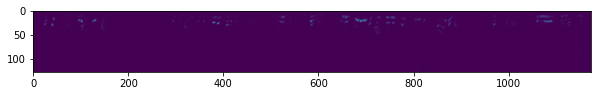

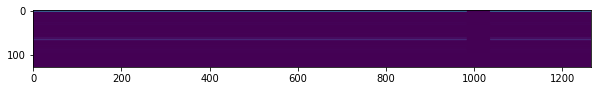

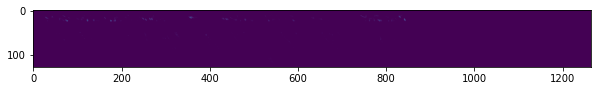

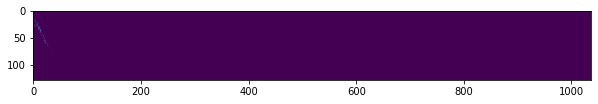

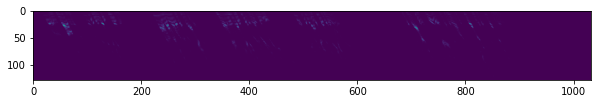

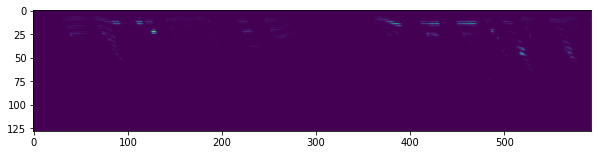

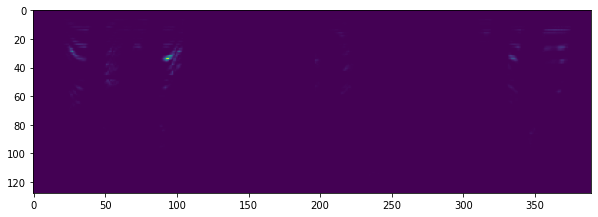

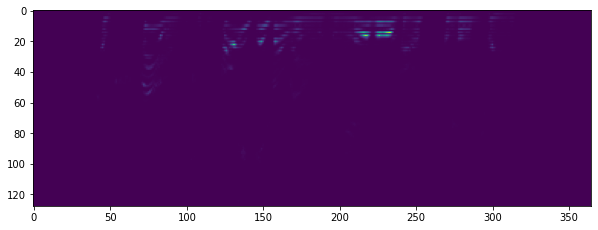

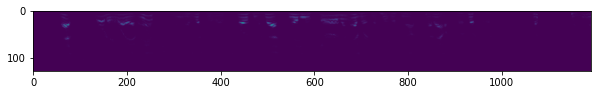

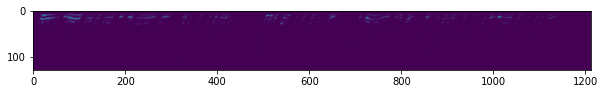

In [13]:
#!L
# For train you can use SpecAugment data aug here.
n_mels=128

train_audio_transforms = nn.Sequential(
    # torchaudio.transforms.AmplitudeToDB(),
    torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_mels=n_mels),
    SpecAugment()
)

test_audio_transforms = torchaudio.transforms.MelSpectrogram()

tokenizer = Tokenizer()


def data_processing(data, data_type="train"):
    spectrograms = []
    labels = []
    input_lengths = []
    label_lengths = []
    for (waveform, _, utterance, _, _, _) in data:
        if data_type == 'train':
            spec = train_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        elif data_type == 'test':
            spec = test_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        else:
            raise Exception('data_type should be train or valid')
        spectrograms.append(spec)
        label = torch.Tensor(tokenizer.text_to_indecies(utterance.lower()))
        labels.append(label)
        input_lengths.append(spec.shape[0] // 2)
        label_lengths.append(len(label))

    spectrograms = nn.utils.rnn.pad_sequence(spectrograms, batch_first=True).unsqueeze(1).transpose(2, 3)
    labels = nn.utils.rnn.pad_sequence(labels, batch_first=True)

    return spectrograms, labels, input_lengths, label_lengths


for idx in random.sample(range(len(train_dataset)), 10):
    show_sample(
        train_audio_transforms(train_dataset[idx][0])[0]
    )

In [14]:
trainset_processed = data_processing(train_dataset)

/home/ishalyminov/data/miniconda3/envs/shad_speech/lib/python3.7/site-packages/ipykernel_launcher.py:327: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [15]:
testset_processed = data_processing(test_dataset, data_type='test')

## Implement a Neural Network Model

You should try out a few different model types:
- Feed-Forward Model (DNN)
- Recurrent Model (GRU or LSTM)
- Bidirectional Recurrent Model (bi-GRU or bi-LSTM)
- Something different for bonus points

Before any of this models you can use convolutional layers, as shown in the example below

After your experiments you should write a report with comparison of different models in terms of different features, for example: parameters, training speed, resulting quality, spectrogram properties, and data augmentations. Remember, that for full mark you need to achive good WER 

WER criterions: 60-50 -- 3 points, 50-40 -- 5 points, 40-35 -- 7 points, <= 35 -- 10 points

### Our model classes are just examples, you can change them as you want

In [18]:
#!L
# Define model
class CNNLayerNorm(nn.Module):
    """Layer normalization built for CNNs input"""

    def __init__(self, n_feats):
        super(CNNLayerNorm, self).__init__()
        self.layer_norm = nn.LayerNorm(n_feats)

    def forward(self, x):
        # x (batch, channel, feature, time)
        x = x.transpose(2, 3).contiguous()  # (batch, channel, time, feature)
        x = self.layer_norm(x)
        return x.transpose(2, 3).contiguous()  # (batch, channel, feature, time)


class ResidualCNN(nn.Module):
    """Residual CNN inspired by https://arxiv.org/pdf/1603.05027.pdf
        except with layer norm instead of batch norm
    """

    def __init__(self, in_channels, out_channels, kernel, stride, dropout, n_feats):
        super(ResidualCNN, self).__init__()

        self.cnn1 = nn.Conv2d(in_channels, out_channels, kernel, stride, padding=kernel // 2)
        self.cnn2 = nn.Conv2d(out_channels, out_channels, kernel, stride, padding=kernel // 2)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.layer_norm1 = CNNLayerNorm(n_feats)
        self.layer_norm2 = CNNLayerNorm(n_feats)

    def forward(self, x):
        residual = x  # (batch, channel, feature, time)
        step_1 = self.layer_norm1(self.dropout1(self.cnn1(x)))
        step_2 = self.layer_norm2(self.dropout2(self.cnn2(step_1 + residual)))
        return step_2  # (batch, channel, feature, time)


class SpeechRecognitionModel(nn.Module):

    def __init__(self, n_cnn_layers, n_rnn_layers, rnn_dim, n_class, n_feats, stride=2, dropout=0.1):
        super(SpeechRecognitionModel, self).__init__()
        n_feats = n_feats // 2
        self.cnn = nn.Conv2d(1, 32, 3, stride=stride, padding=3 // 2)  # cnn for extracting heirachal features

        # n residual cnn layers with filter size of 32
        self.rescnn_layers = nn.Sequential(*[
            ResidualCNN(32, 32, kernel=3, stride=1, dropout=dropout, n_feats=n_feats)
            for _ in range(n_cnn_layers)
        ])
        self.fully_connected = nn.Linear(n_feats, n_feats)
        self.birnn_layers = nn.GRU(n_feats, rnn_dim, num_layers=n_rnn_layers, bidirectional=True)
        self.classifier = nn.Linear(rnn_dim, n_class)

    def forward(self, x):
        x = self.cnn(x)
        x = self.rescnn_layers(x)
        sizes = x.size()
        x = x.view(sizes[0], sizes[1] * sizes[2], sizes[3])  # (batch, feature, time)
        x = x.transpose(1, 2)  # (batch, time, feature)
        x = self.fully_connected(x)
        x = self.birnn_layers(x)
        x = self.classifier(x)
        return x

## Training and Evaluation Code

In [19]:
#!L
from tqdm import tqdm_notebook

In [20]:
#!L
def train(model, device, train_loader, criterion, optimizer, scheduler, epoch):
    model.train()
    data_len = len(train_loader.dataset)
    for batch_idx, _data in enumerate(train_loader):
        spectrograms, labels, input_lengths, label_lengths = _data
        spectrograms, labels = spectrograms.to(device), labels.to(device)

        optimizer.zero_grad()

        output = model(spectrograms)  # (batch, time, n_class)
        output = F.log_softmax(output, dim=2)
        output = output.transpose(0, 1)  # (time, batch, n_class)

        loss = criterion(output, labels, input_lengths, label_lengths)
        loss.backward()

        optimizer.step()
        scheduler.step()
        if batch_idx % 100 == 0 or batch_idx == data_len:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(spectrograms), data_len,
                       100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader, criterion, epoch, decode='Greedy', lm=None):
    print('Beginning eval...')
    model.eval()
    test_loss = 0
    test_cer, test_wer = [], []
    with torch.no_grad():
        start = time.time()
        for i, _data in enumerate(test_loader):
            spectrograms, labels, input_lengths, label_lengths = _data
            spectrograms, labels = spectrograms.to(device), labels.to(device)
            
            matrix = model(spectrograms)  # (batch, time, n_class)
            matrix = F.log_softmax(matrix, dim=2)
            probs = F.softmax(matrix,dim=2)
            matrix = matrix.transpose(0, 1)  # (time, batch, n_class)
                
            loss = criterion(matrix, labels, input_lengths, label_lengths)
            test_loss += loss.item() / len(test_loader)

            if decode == 'Greedy':
                decoded_preds, decoded_targets = GreedyDecoder(matrix.transpose(0, 1), labels, label_lengths)
            elif decode == 'BeamSearch':
                ## THIS IS A CLASS YOU SHOULD IMPLEMENT
                decoded_preds, decoded_targets = BeamSearchDecoder(probs, labels, label_lengths, input_lengths, lm=lm)
            for j in range(len(decoded_preds)):
                test_cer.append(cer(decoded_targets[j], decoded_preds[j]))
                test_wer.append(wer(decoded_targets[j], decoded_preds[j]))

    avg_cer = sum(test_cer) / len(test_cer)
    avg_wer = sum(test_wer) / len(test_wer)

    print(
        'Epoch: {:d}, Test set: Average loss: {:.4f}, Average CER: {:4f} Average WER: {:.4f}\n'.format(epoch, test_loss,
                                                                                                       avg_cer,
                                                                                                       avg_wer))

In [21]:
#!L
#pragma async 
# PRAGMA ASYNC IS NECESSARY FOR TRAINING!
torch.manual_seed(7)
if torch.cuda.is_available():
    print('GPU found! 🎉')
    device = 'cuda'
else:
    print('Only CPU found! 💻')
    device = 'cpu'

verbose=False

# Hyperparameters for your model
hparams = {
    "n_cnn_layers": 3,
    "n_rnn_layers": 2,
    "rnn_dim": 128,
    "n_class": 29,
    "n_feats": 128,
    "stride": 2,
    "dropout": 0.1,
    "learning_rate":  5e-4,
    "batch_size":  10,
    "epochs": 20
}

# Define Dataloyour training and test data loaders
kwargs = {'num_workers': 1, 'pin_memory': True} if device=='cuda' else {}
train_loader = data.DataLoader(
    trainset_processed,
    batch_size=hparams['batch_size'],
    shuffle=True, 
    num_workers=1,
    drop_last=True
)
test_loader = data.DataLoader(
    testset_processed,
    batch_size=hparams['batch_size'],
    shuffle=True, 
    num_workers=1,
    drop_last=False
)
# Define ASR Model 
model = SpeechRecognitionModel(
    hparams['n_cnn_layers'], hparams['n_rnn_layers'], hparams['rnn_dim'],
    hparams['n_class'], hparams['n_feats'], hparams['stride'], hparams['dropout']
).to(device)

model.to(device)

if verbose:
    print(model)
print('Num Model Parameters', sum([param.nelement() for param in model.parameters()]))

#Define optimizineer, criterion, scheduler
optimizer = torch.optim.Adam(lr=hparams['learning_rate'], params=model.parameters())
criterion = torch.nn.functional.cross_entropy
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=hparams['learning_rate'],
    epochs=hparams['epochs'],
    steps_per_epoch=math.ceil(len(trainset_processed[0]) / hparams['batch_size']))


#iter_meter = IterMeter()
start = time.time()
print("Start training...")
for epoch in range(1, hparams['epochs'] + 1):
    ep_start = time.time()
    train(model, device, train_loader, criterion, optimizer, scheduler, epoch)
    #if epoch % 2 == 0:
    save_checkpoint(model, checkpoint_name=f'model_epoch{epoch}.tar')
    load_checkpoint(model, checkpoint_name=f'model_epoch{epoch}.tar', path='./', device=device)
    test(model, device, test_loader, criterion, epoch)
    print(f"Time for epoch: {round(time.time() - ep_start, 0)} sec.")
save_checkpoint(model, checkpoint_name=f'model.tar')
duration = time.time() - start
print(f'Training took {np.round(duration / 60.0, 1)} min.')

GPU found! 🎉
Num Model Parameters 509917
Start training...


OSError: [Errno 12] Cannot allocate memory

In [ ]:
#!L
# Test the model in Prefix Decode Mode - only do after you have implemented your prefix decoder

test(model, device, test_loader, criterion, epoch, decode='BeamSearch', lm=None)

alm = arpa.loadf('3-gram.pruned.1e-7.arpa')[0]
test(model, device, test_loader, criterion, epoch, decode='BeamSearch', lm=alm)

## Compare different models: DNN, GRU/LSTM, bi-GRU/bi-LSTM (5 points)

## Analyze CTC Alignments (5 points)

## In this section you should compare alignments obtained from different models.

For example, you can show:

* Examples of alignments and their analysis
* Differencies in the properties of alignment distributions over the dataset
* Dynamic of alignments during training (from checkpoints)
* Connection between alignments and model loss


In [ ]:
#!L
def forward_algorithm(sequence, matrix, blank=28):
    # Matrix is has shape [K, T]

    # Turn probs into log-probs
    # matrix = np.log(matrix)

    # Create modified sequence which with START, END blanks and between each character
    mod_sequence = [sequence[int((i-1)/2)] if i % 2 !=0 else blank for i in range(len(sequence)*2+1)]

    # Initialze
    alphas = np.full([len(mod_sequence), matrix.shape[1]], 0.0)

    for t in range(matrix.shape[1]):
        for s in range(len(mod_sequence)):
            #First Step
            if t == 0 and (0 <= s <= 1):
                alphas[s, t] = matrix[mod_sequence[s], t]
            else:
                # Need to do this stabily
                a_t_1_s = alphas[s, t - 1] if 0 < t else 0.0
                a_t_1_s_1 = alphas[s - 1, t - 1] if 0 < t and 0 < s else 0.0
                a_t_1_s_2 = alphas[s - 2, t - 1] if 0 < t and 1 < s else 0.0
                if mod_sequence[s] == blank or (1 < s and mod_sequence[s] == mod_sequence[s - 2]):
                    alphas[s, t] = (a_t_1_s + a_t_1_s_1) * matrix[mod_sequence[s], t]
                else:
                    alphas[s, t] = (a_t_1_s + a_t_1_s_1 + a_t_1_s_2) * matrix[mod_sequence[s], t]
        c_t = np.sum(alphas[:, t])
        alphas[:, t] = alphas[:, t] / c_t
    return alphas

def backward_algorithm(sequence, matrix, blank=28):
    # Matrix has shape [K, T] where K - 29 

    # Turn probs into log-probs
    # matrix = np.log(matrix)

    # Create modified sequence which with START, END blanks and between each character
    mod_sequence = [sequence[int((i-1)/2)] if i % 2 !=0 else blank for i in range(len(sequence)*2+1)]

    betas = np.full([len(mod_sequence), matrix.shape[1]], 0.0)

    for t in reversed(range(matrix.shape[1])):
        for s in reversed(range(len(mod_sequence))):
            #First Step
            if t == matrix.shape[1]-1:
                if s == len(mod_sequence) - 1:
                    betas[s, t] = matrix[blank, -1]
                elif s == len(mod_sequence) - 2:
                    betas[s, t] = matrix[mod_sequence[-2], -1]

            else:
                b_t_1_s = betas[s, t + 1] if t < matrix.shape[1] - 1 else 0.0
                b_t_1_s_1 = betas[s + 1, t + 1] if t < matrix.shape[1] - 1 and s < len(mod_sequence) - 1 else 0.0
                b_t_1_s_2 = betas[s + 2, t + 1] if t < matrix.shape[1] - 1 and s < len(mod_sequence) - 2 else 0.0

                if mod_sequence[s] == blank or (s < len(mod_sequence) - 2 and mod_sequence[s] == mod_sequence[s + 2]):
                    betas[s, t] = (b_t_1_s + b_t_1_s_1) * matrix[mod_sequence[s], t]
                else:
                    betas[s, t] = (b_t_1_s + b_t_1_s_1 + b_t_1_s_2) * matrix[mod_sequence[s], t]
        d_t = np.sum(betas[:, t])
        betas[:, t] = betas[:, t] / d_t
    return betas

def soft_alignment(labels_indecies, matrix):
    alphas = forward_algorithm(labels_indecies, matrix)
    betas = backward_algorithm(labels_indecies, matrix)

    # Move from log space back to prob space
    align = alphas * betas

    # Normalize Alignment
    col_sums = [np.sum(align[:, j]) for j in range(align.shape[1])]
    for i in range(align.shape[0]):
        for j in range(align.shape[1]):
            align[i, j] /= col_sums[j]

    return align

In [ ]:
#!L
# Test your implementation of CTC
#Load numpy matrix, add axis [classes,time]
matrix = np.loadtxt(os.path.join(week_05_path, 'test_matrix.txt'))
# Create label_sequence
tokenizer = Tokenizer()
labels_indecies = tokenizer.text_to_indecies('there se ms no good reason for believing that twillc ange')

align = soft_alignment(labels_indecies, matrix)

ref_align = np.loadtxt(os.path.join(week_05_path, 'soft_alignment.txt'))

# assert np.all(ref_align == align)

In [ ]:
#Example
model.eval()
_data = next(iter(test_loader))
spectrograms, labels, input_lengths, label_lengths = _data
spectrograms, labels = spectrograms.to(device), labels.to(device)

matrix = model(spectrograms).transpose(1,2)  # (batch, n_class, time)

In [ ]:
# Example of alignment calculation:
with torch.no_grad():
  align = soft_alignment(labels[0].int().cpu().numpy(), F.softmax(matrix[0],dim=0).cpu().numpy())

In [ ]:
plt.figure(dpi=150)
plt.imshow(align, aspect='auto', interpolation='nearest')
plt.colorbar()

plt.figure(dpi=150)
plt.imshow(np.log(align), aspect='auto', interpolation='nearest')
plt.colorbar()

### Conclusions 🧑‍🎓

* What challenges did you encounter while completing this task?
* What skills have you acquired while doing this task?
* How difficult did you find this task (on a scale from 0 to 10), and why?
* What did you like in this homework, and what didn't?